

<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## PGE 383 Graduate Student Project Template 

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)





## Bootstrap Linear Regression

#### Yuanrui Zhu
#### Hilderbrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Misael Morales, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/misaelmmorales/)


### Executive Summary

The goal of this project is to compare sampling distribution to analytical expression for confidence intervals and use a creative method to display the uncertainty. In this study, we establihsed bootstrap linear regression model to study the confidence interval of regression coefficients and analyzed the influence of outliters and conditional variance dataset on the distribution of the regression coefficients. Compared with simple linear regression model, bootstrap linear regression model gives us insight into how much random variation in regression coefficients, although both of them are sensitive to outliers. Through this project, we found that bootstrap linear regression model is a very useful and robust resamping method because it makes minimal assumptions about parent distribution and is well implemented into many languages and packages.

### Import Packages



In [1]:
import numpy as np                                        # arrays and matric math
import matplotlib.pyplot as plt                           # for plotting
import pandas as pd                                       # DataFrames   
import random                                             # for random sampling with replacement
import statsmodels.formula.api as sm                      # for linear regression model

### Load Data

The following workflow applies the .csv file 'Density_Por_data.csv' dataset, which is available in Dr. Pyrcz's GitHub repository.

We will work with the following features:

* **Porosity** - fraction of rock void in units of percentage
* **Density** - the mass per volume;$g/cm^3$




In [2]:
#load data and preview table
df = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/Density_Por_data.csv") # load data from Dr. Pyrcz's GitHub repository
df.head() 

,Density,Porosity
0,1.281391,16.610982
1,1.404932,13.668073
2,2.346926,9.590092
3,1.348847,15.877907
4,2.331653,4.968240


In [3]:
df.describe().transpose()  

,count,mean,std,min,25%,50%,75%,max
Density,105.0,1.737917,0.288278,0.996736,1.552713,1.748788,1.906634,2.410560
Porosity,105.0,12.531279,3.132269,4.966421,10.546483,12.411608,14.230930,20.964941


In [4]:
# build original dataset
por=df['Porosity']
den=df['Density']
data_df = pd.DataFrame({'x': den, 'y': por})

### Workflow of Bootstrap Linear Regression


1. Establish a linear regression model of porosity and density

2. Establish bootstrap observations and bootstrap residuals models

3. Investigate the influence of outliers

4. Investigate the influence of conditional variance

### 1. Establish a linear regression model of porosity and density

At the very beginning, we are going to establish a linear regression model to characterize the linear relationship between rock density and porosity. In this univariate problem, the linear regression coefficients are slope and intercept.

In [5]:
# establish simple linear regression model on original dataset
ols_model = sm.ols(formula = 'y ~ x', data=data_df)  
results = ols_model.fit()
print('The linear regression model for original dataset is shown:')
print('Intercept:'+str(round(results.params[0],2)) +', Slope:'+str(round(results.params[1],2)))
y_pred = ols_model.fit().predict(data_df['x'])

The linear regression model for original dataset is shown:
Intercept:28.35, Slope:-9.1


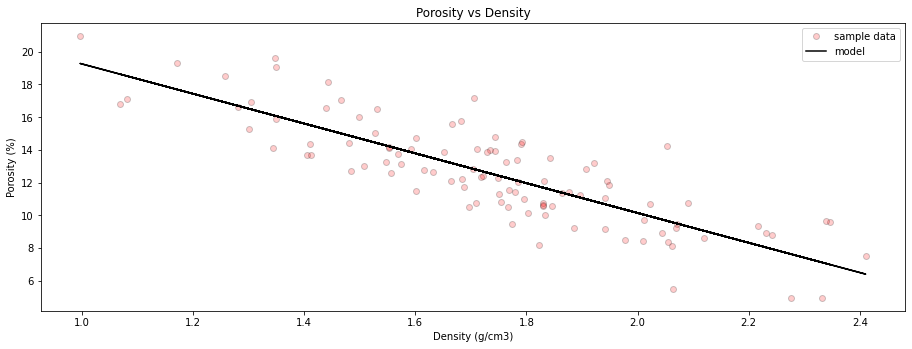

In [6]:
# plot the model and original dataset
plt.subplot(111)
plt.plot(den, por, 'o',label='sample data',color='red',alpha=0.2,markeredgecolor='black')
plt.plot(den, y_pred, label='model', color = 'black')
plt.title('Porosity vs Density')
plt.xlabel('Density (g/cm3)')
plt.ylabel('Porosity (%)')
plt.legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.show()


As shown in the above figure, there is a strong linear relationship between density and porosity.

### 2. Establish bootstrap observations and bootstrap residuals models

The bootstrap linear regression can be divided into two kinds of methods: bootstrap observations and bootstrap residuals. Both of these two methods give us several sets of regression coefficients for the density vs porosity linear relationship and confidence interval of these coefficients. 

1. The bootstrap observations method performs 1000 trials, which resamples with replacement these 105 observations from sample dataset, then runs the regression model and saves the regression coefficients we got. Finally, the distributions of these coefficients are obtained.

2. The bootstrap residuals method require us to calculate the residuals of these 105 observations at first. Then 1000 trials are performed, which resamples with replacement these 105 residuals. So we would have 1000 pairs of 105 residuals. Calculate the fitted porosity values based on each pair 105 residuals and regress these new porosity values onto the density values to obtain bootstrap regression coefficients. Finally, the distributions of these coefficients are obtained.


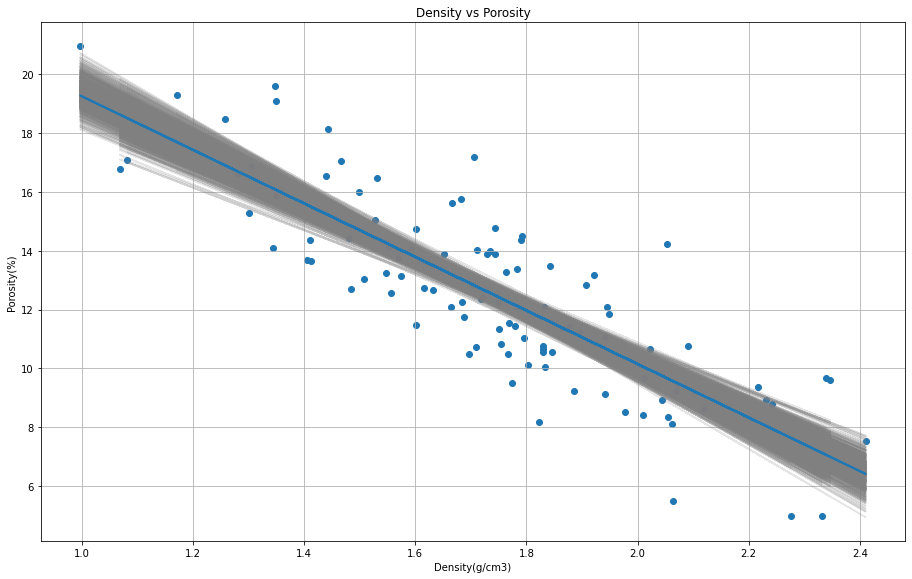

In [8]:
# method1: Bootstrap observations
# resample with replacement each row
n_points=105
boot_slopes1 = []
boot_interc1 = []
n_boots = 1000
plt.figure()
for _ in range(n_boots):    #code from Jams Andrew Godwin,https://towardsdatascience.com/linear-regression-with-bootstrapping-4924c05d2a9
 # sample the rows, same size, with replacement
 sample_df1 = data_df.sample(n=n_points, replace=True)
 # fit a linear regression
 ols_model_temp1 = sm.ols(formula = 'y ~ x', data=sample_df1)
 results_temp1 = ols_model_temp1.fit()
 # append regression coefficients
 boot_interc1.append(results_temp1.params[0])
 boot_slopes1.append(results_temp1.params[1])
 # plot a greyed out line
 y_pred_temp1 = ols_model_temp1.fit().predict(sample_df1['x'])
 plt.plot(sample_df1['x'], y_pred_temp1, color='grey', alpha=0.2)

# add data points
plt.scatter(den, por)
plt.plot(den, y_pred, linewidth=2) #plot the simple linear regression model results
plt.grid(True)
plt.xlabel('Density(g/cm3)')
plt.ylabel('Porosity(%)')
plt.title('Density vs Porosity')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.8, wspace=0.2, hspace=0.2) 
plt.show()

In the above figure, the blue dots are the original dataset, the blue line is the simple linear regression model of the original dataset and the grey lines are linear regression models of 1000 relizations of dataset obtained by bootstrapping. As shown in the figure, the simple linear regression model(blue line) lays in the range of the bootstrap linear regression models(grey lines).
In the next step, we are going to study the distribution of the slope and intercept of these bootstrap linear regression models(grey lines).

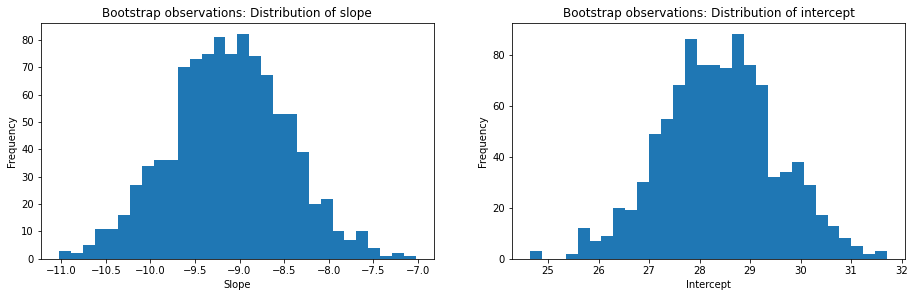

The mean and variance of regression coefficient distributions under bootstrap observations method are shown:
The mean of the slope is -9.12, the variance of the slope is 0.43
The mean of the intercept is 28.39, the variance of the intercept is 1.3


In [9]:
# plot the distribution of the regression coefficients
plt.subplot(2,2,1)
plt.hist(boot_slopes1, bins = 30)
plt.xlabel("Slope")
plt.ylabel("Frequency")
plt.title("Bootstrap observations: Distribution of slope");

plt.subplot(2,2,2)
plt.hist(boot_interc1, bins = 30)
plt.xlabel("Intercept")
plt.ylabel("Frequency")
plt.title("Bootstrap observations: Distribution of intercept");


plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.8, wspace=0.2, hspace=0.2) 
plt.show()

print('The mean and variance of regression coefficient distributions under bootstrap observations method are shown:')
print('The mean of the slope is ' + str(round(np.mean(boot_slopes1),2))+', the variance of the slope is '+ str(round(np.var(boot_slopes1),2)))
print('The mean of the intercept is ' + str(round(np.mean(boot_interc1),2))+', the variance of the intercept is '+ str(round(np.var(boot_interc1),2)))


Compared with linear regression model, bootstrap linear regression model gives us the distribution of the regression coefficients to display the uncertainty of the linear regression model.

[]

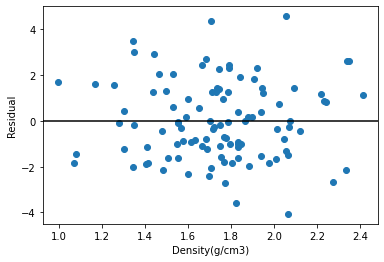

In [10]:
# method 2:Bootstrap residuals
# get residual values
resids = results.resid
plt.scatter(den,resids)
plt.xlabel("Density(g/cm3)")
plt.ylabel("Residual")
plt.axhline(y=0.0,color='black',linestyle='-')
plt.plot()

As shown in the above figure, the variance is almost constant and doesn't change with the density value.

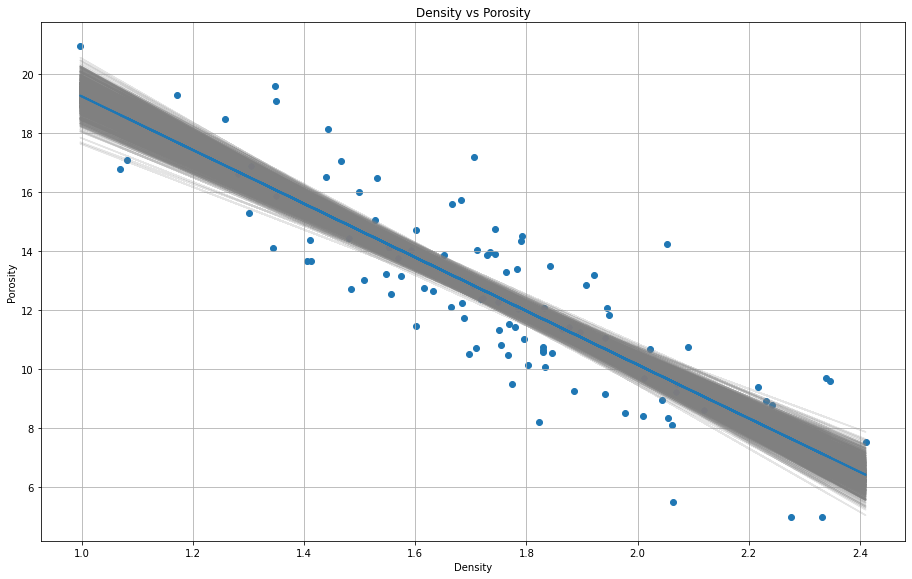

In [12]:
boot_slopes2 = []
boot_interc2 = []
n_boots = 1000
plt.figure()
for _ in range(n_boots):  #code from Jams Andrew Godwin,https://towardsdatascience.com/linear-regression-with-bootstrapping-4924c05d2a9
 # create a sampling of the residuals with replacement
 boot_resids = np.random.choice(resids, n_points, replace=True)
    
 y_temp2 = [y_pred_i + resid_i for y_pred_i, resid_i in zip(y_pred, boot_resids)]
 sample_df2 = pd.DataFrame({'x': list(den), 'y': y_temp2})
 # Fit a linear regression
 ols_model_temp2 = sm.ols(formula = 'y ~ x', data=sample_df2)
 results_temp2 = ols_model_temp2.fit()
 
 # get regression coefficients
 boot_interc2.append(results_temp2.params[0])
 boot_slopes2.append(results_temp2.params[1])
 
 # plot a greyed out line
 y_pred_temp2 = ols_model_temp2.fit().predict(sample_df2['x'])
 plt.plot(sample_df2['x'], y_pred_temp2, color='grey', alpha=0.2)

# add data points
plt.scatter(den, por)
plt.plot(den, y_pred, linewidth=2)
plt.grid(True)
plt.xlabel('Density')
plt.ylabel('Porosity')
plt.title('Density vs Porosity')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.8, wspace=0.2, hspace=0.2) 
plt.show()

In the above figure, the blue dots are the original dataset, the blue line is the simple linear regression model of the original dataset and the grey lines are linear regression models based on 1000 relizations of residual dataset obtained by bootstrapping. As shown in the figure, the simple linear regression model(blue line) lays in the range of the bootstrap linear regression models(grey lines). The result of the bootstrap residuals method is similar with that of bootstrap observations method.

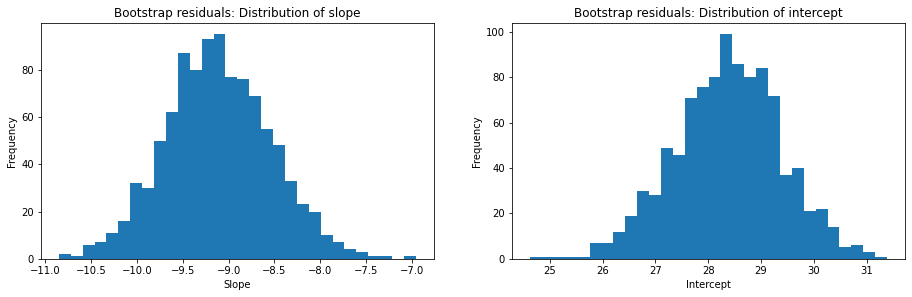

The mean of the slope is -9.12, the variance of the slope is 0.33
The mean of the intercept is 28.37, the variance of the intercept is 1.02


In [13]:
# plot the distribution of the regression coefficients
plt.subplot(2,2,1)
plt.hist(boot_slopes2, bins = 30)
plt.xlabel("Slope")
plt.ylabel("Frequency")
plt.title("Bootstrap residuals: Distribution of slope");

plt.subplot(2,2,2)
plt.hist(boot_interc2, bins = 30)
plt.xlabel("Intercept")
plt.ylabel("Frequency")
plt.title("Bootstrap residuals: Distribution of intercept");


plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.8, wspace=0.2, hspace=0.2) 
plt.show()

print('The mean of the slope is ' + str(round(np.mean(boot_slopes2),2))+', the variance of the slope is '+ str(round(np.var(boot_slopes2),2)))
print('The mean of the intercept is ' + str(round(np.mean(boot_interc2),2))+', the variance of the intercept is '+ str(round(np.var(boot_interc2),2)))


Compared with linear regression model, these two bootstrap linear regression methods give us the distribution of the regression coefficients of the linear regression model instead of a certain set of value.

### 3. Investigate the influence of outliers

In this sector, we are going to introduce two outliers in our dataset, and repeat the above process to investigate the influence of outliers on the simple linear regression model and bootstrap linear regression model. For samplicity, we only show the simple linear regression model and bootstrap observations model.


In [14]:
#introduce two outliers in our dataset
outlier=[[2.2,2.1],[19.0,18.0]]
por_outlier=pd.concat([df['Porosity'],pd.Series(outlier[1])])
den_outlier=pd.concat([df['Density'],pd.Series(outlier[0])])
data_df_outlier = pd.DataFrame({'x': den_outlier, 'y': por_outlier})

# establish a linear regression model based on updated dataset
ols_model_outlier = sm.ols(formula = 'y ~ x', data=data_df_outlier)
results_outlier = ols_model_outlier.fit()
print('The linear regression model for dataset with outlier is shown:')
print('Intercept:'+str(round(results_outlier.params[0],2))+ ', Slope:'+str(round(results_outlier.params[1],2)))
y_pred_outlier = ols_model_outlier.fit().predict(data_df_outlier['x'])


The linear regression model for dataset with outlier is shown:
Intercept:26.99, Slope:-8.22


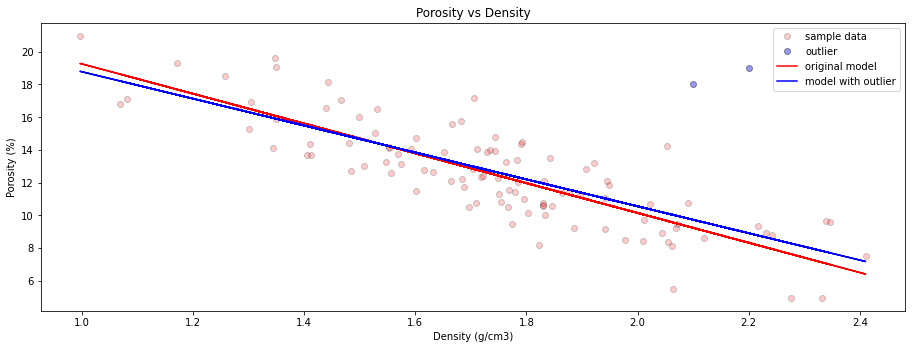

In [15]:
#plot the updated dataset and updated linear regression model
plt.subplot(111)
plt.plot(den, por, 'o',label='sample data',color='red',alpha=0.2,markeredgecolor='black')
plt.plot(outlier[0],outlier[1],'o',label='outlier',color='blue',alpha=0.4,markeredgecolor='black')
plt.plot(den,y_pred,label='original model',color='red')
plt.plot(den_outlier, y_pred_outlier, label='model with outlier', color = 'blue')

plt.title('Porosity vs Density')
plt.xlabel('Density (g/cm3)')
plt.ylabel('Porosity (%)')
plt.legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.show()

Since the introduction of the outliers, the slope of the linear regression model increase, and the intercept decrease.

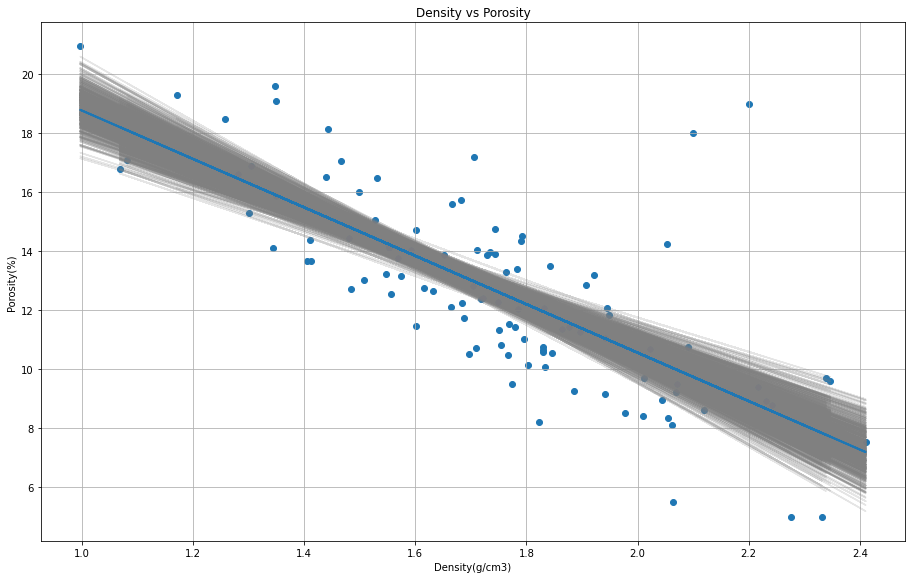

In [16]:
#establish bootstrap observations model based on updated dataset
# resample with replacement each row
n_points_outlier=107
boot_slopes_outlier = []
boot_interc_outlier = []
n_boots = 1000
plt.figure()
for _ in range(n_boots):
 # sample the rows, same size, with replacement
 sample_df_outlier = data_df_outlier.sample(n=n_points_outlier, replace=True)
 # fit a linear regression
 ols_model_temp_outlier = sm.ols(formula = 'y ~ x', data=sample_df_outlier)
 results_temp_outlier = ols_model_temp_outlier.fit()
 
 # append regression coefficients
 boot_interc_outlier.append(results_temp_outlier.params[0])
 boot_slopes_outlier.append(results_temp_outlier.params[1])
 # plot a greyed out line
 y_pred_temp_outlier = ols_model_temp_outlier.fit().predict(sample_df_outlier['x'])
 plt.plot(sample_df_outlier['x'], y_pred_temp_outlier, color='grey', alpha=0.2)


# add data points
plt.scatter(den_outlier, por_outlier)
plt.plot(den_outlier, y_pred_outlier, linewidth=2)
plt.grid(True)
plt.xlabel('Density(g/cm3)')
plt.ylabel('Porosity(%)')
plt.title('Density vs Porosity')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.8, wspace=0.2, hspace=0.2) 
plt.show()

In the above figure, the blue dots are the original dataset, the blue line is the simple linear regression model of the original dataset and the grey lines are linear regression models of 1000 relizations of dataset obtained by bootstrapping. As shown in the figure, the simple linear regression model(blue line) lays in the range of the bootstrap linear regression models(grey lines). Compared with the results of bootstrap linear regression model before the introduction of the outliers, the area occupied by the bootstrap linear regression models (grey lines) increase.

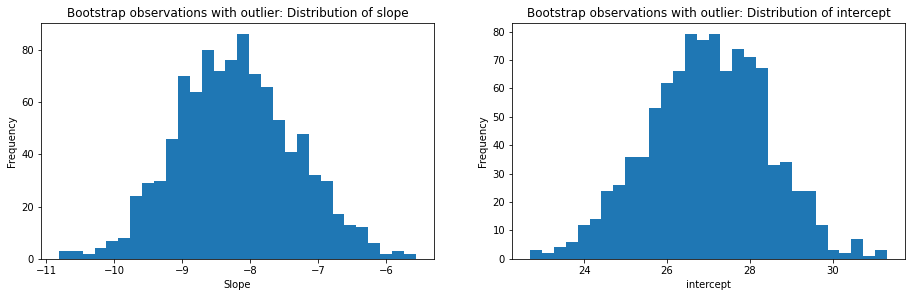

The mean and variance of regression coefficient distributions under bootstrap observations method with outlier are shown:
The mean of the slope is -8.21, the variance of the slope is 0.75
The mean of the intercept is 26.98, the variance of the intercept is 2.07


In [17]:
#plot the distribution of the regression coefficients
plt.subplot(2,2,1)
plt.hist(boot_slopes_outlier, bins = 30)
plt.xlabel("Slope")
plt.ylabel("Frequency")
plt.title("Bootstrap observations with outlier: Distribution of slope");

plt.subplot(2,2,2)
plt.hist(boot_interc_outlier, bins = 30)
plt.xlabel("intercept")
plt.ylabel("Frequency")
plt.title("Bootstrap observations with outlier: Distribution of intercept");


plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.8, wspace=0.2, hspace=0.2) 
plt.show()
print('The mean and variance of regression coefficient distributions under bootstrap observations method with outlier are shown:')
print('The mean of the slope is ' + str(round(np.mean(boot_slopes_outlier),2))+', the variance of the slope is '+ str(round(np.var(boot_slopes_outlier),2)))
print('The mean of the intercept is ' + str(round(np.mean(boot_interc_outlier),2))+', the variance of the intercept is '+ str(round(np.var(boot_interc_outlier),2)))



The mean of the slope and intercept from bootstrap linear regression mehthod are almost same as that in sample linear regression model, which shows the bootstrap linear regression model is not sensitive to the outliers.

### 4. Investigate the influence of conditional variance

In this sector, we are going to creat a dataset with conditional variance to investigate the influence of conditional variance on bootstrap observations and bootstrap residuals methods.


Text(0, 0.5, 'Porosity(%)')

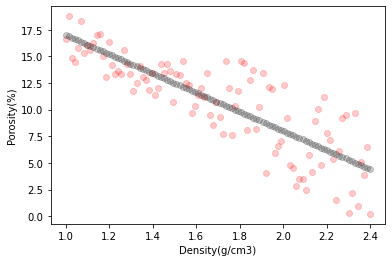

In [18]:
# creat a por vs den dataset with conditional variance
n_points=100
x=np.linspace(1.0,2.4,n_points)
x1=x[0:50]
x2=x[50:100]
y1=-9.0*x1+26.0+(np.random.rand(len(x1)) * 5)-2.5
y2=-9.0*x2+26.0+(np.random.rand(len(x2)) * 10)-5
y_center=-9.0*x+26.0
y=np.hstack((y1,y2))
data_df_var=pd.DataFrame({'x':x,'y':y})

#plot this conditional variance dataset
plt.scatter(x,y,color='red',alpha=0.2)
plt.scatter(x,y_center,color='black',alpha=0.2)
plt.xlabel('Density(g/cm3)')
plt.ylabel('Porosity(%)')


As shown in the above figure, the dataset is conditonal variance. The variance with the density less than 1.6 g/cm3 is lesser than that with density larger than 1.6g/cm3. 

In [19]:
#build simple linear regression model for the dataset with conditional variance
ols_model_var = sm.ols(formula = 'y ~ x', data=data_df_var)
results_var = ols_model_var.fit()
print('Intercept: '+str(round(results_var.params[0],2))+', Slope: '+str(round(results_var.params[1],2)))
y_pred_var = ols_model_var.fit().predict(data_df_var['x'])


Intercept: 25.79, Slope: -8.93


We establish a simple linear regression model based on the created conditonal variance dataset and calculate the slope and intercept of the model.

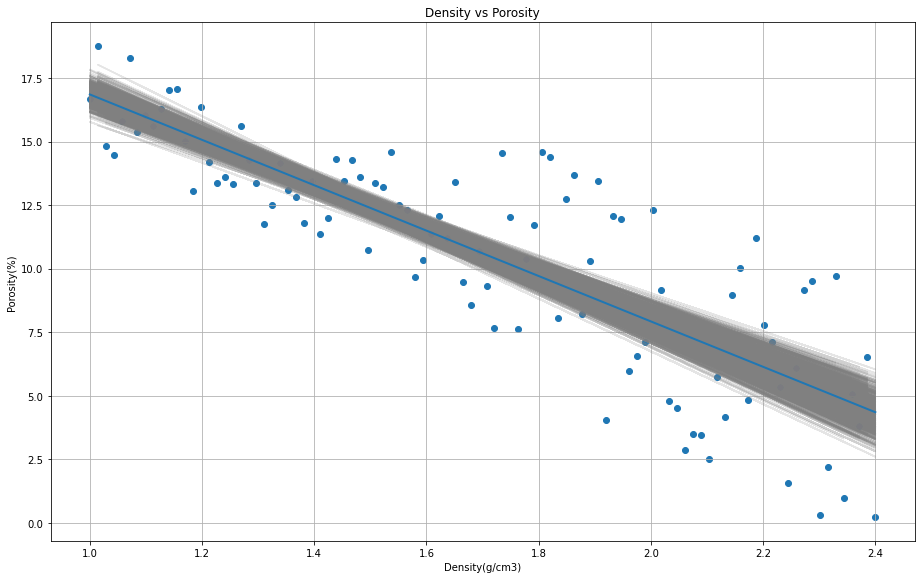

In [20]:
# method 1: Bootstrap observations
# resample with replacement each row
n_points_var=100
boot_slopes_var1 = []
boot_interc_var1 = []
y_predict1_var1=[]
y_predict2_var1=[]
n_boots = 1000
plt.figure()
for _ in range(n_boots):
 # sample the rows, same size, with replacement
 sample_df_var1 = data_df_var.sample(n=n_points_var, replace=True)
 # fit a linear regression
 ols_model_temp_var1 = sm.ols(formula = 'y ~ x', data=sample_df_var1)
 results_temp_var1 = ols_model_temp_var1.fit()
 
 # append regression coefficients
 boot_interc_var1.append(results_temp_var1.params[0])
 boot_slopes_var1.append(results_temp_var1.params[1])
 # plot a greyed out line
 y_pred_temp_var1 = ols_model_temp_var1.fit().predict(sample_df_var1['x'])
 plt.plot(sample_df_var1['x'], y_pred_temp_var1, color='grey', alpha=0.2)
 # predict values  
 y_predict_obser=results_temp_var1.predict(data_df_var['x'])
 y_predict1_var1.append(y_predict_obser[16])
 y_predict2_var1.append(y_predict_obser[84])


# add data points
plt.scatter(x, y)
plt.plot(x, y_pred_var, linewidth=2)
plt.grid(True)
plt.xlabel('Density(g/cm3)')
plt.ylabel('Porosity(%)')
plt.title('Density vs Porosity')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.8, wspace=0.2, hspace=0.2) 
plt.show()

In the above figure, the blue dots are the original dataset, the blue line is the simple linear regression model of the original dataset and the grey lines are linear regression models of 1000 relizations of dataset obtained by bootstrapping. As shown in the figure, the simple linear regression model(blue line) lays in the range of the bootstrap linear regression models(grey lines). 
The shape of the area occupied by the bootstrap linear regression models(grey lines) of conditional variance dataset is a little different from that of the original dataset. The distribution of predicted porosity when the density is 1.0g/cm3 is much wider than that when density is 2.4g/cm3, which demonstrates that our model can be well applied to conditional variance dataset.

[]

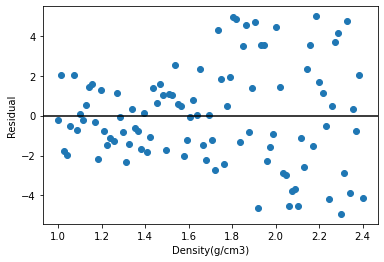

In [21]:
#method 2: Bootstrap residuals
# get residual values
resids = results_var.resid
plt.scatter(data_df_var['x'],resids)
plt.axhline(y=0.0,color='black',linestyle='-')
plt.xlabel('Density(g/cm3)')
plt.ylabel('Residual')
plt.plot()

As shown in the above figure, the variance is not constant and change with the density value. The variance of porosity when density is higher than 1.6 g/cm3 is much larger than that when density is lower than 1.6g/cm3.

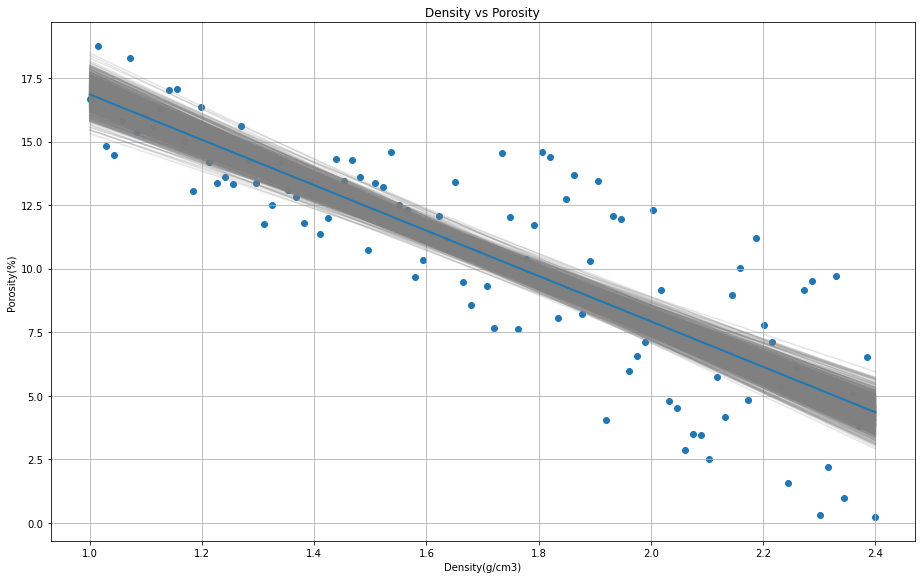

In [22]:
boot_slopes_var2 = []
boot_interc_var2 = []
y_predict1_var2=[]
y_predict2_var2=[]
n_boots = 1000
plt.figure()
for _ in range(n_boots):
 # create a sampling of the residuals with replacement
 boot_resids_var = np.random.choice(resids, n_points_var, replace=True)
 y_temp_var2 = [y_pred_i + resid_i for y_pred_i, resid_i in zip(y_pred_var, boot_resids_var)]
 
 sample_df_var2 = pd.DataFrame({'x': x, 'y': y_temp_var2})
 # Fit a linear regression
 ols_model_temp_var2 = sm.ols(formula = 'y ~ x', data=sample_df_var2)
 results_temp_var2 = ols_model_temp_var2.fit()
 
 # get regression coefficients
 boot_interc_var2.append(results_temp_var2.params[0])
 boot_slopes_var2.append(results_temp_var2.params[1])
 
 # plot a greyed out line
 y_pred_temp_var2 = ols_model_temp_var2.fit().predict(sample_df_var2['x'])
 plt.plot(sample_df_var2['x'], y_pred_temp_var2, color='grey', alpha=0.2)
    

 # predict a value  
 y_predict_resi=results_temp_var2.predict(data_df_var['x'])
 y_predict1_var2.append(y_predict_resi[16])
 y_predict2_var2.append(y_predict_resi[84])

    
# add data points
plt.scatter(x, y)
plt.plot(x, y_pred_var, linewidth=2)
plt.grid(True)
plt.xlabel('Density(g/cm3)')
plt.ylabel('Porosity(%)')
plt.title('Density vs Porosity')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.8, wspace=0.2, hspace=0.2) 
plt.show()

For the bootstrap residuals linear regression method, the distribution of predicted porosity when the density is 1.0g/cm3 is similar as that when density is 2.4g/cm3.
Unlike the bootstrap observations linear regression model, the bootstrap residuals linear regression model can not capture the characteristic of the conditional variance and is not applicable to conditional variance dataset.

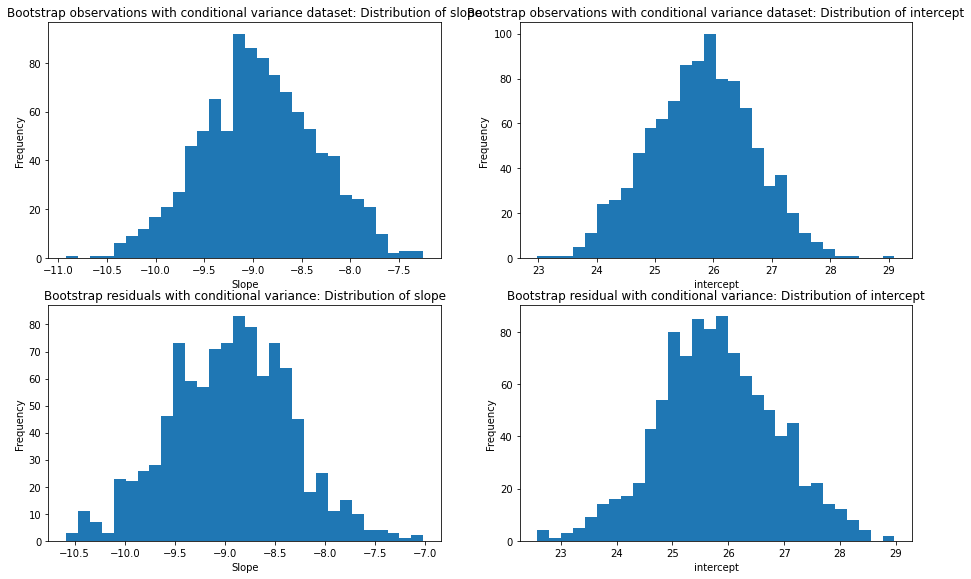

The mean and variance of regression coefficient distributions under bootstrap observations method with conditional variance dataset are shown:
The mean of the slope is -8.93, the variance of the slope is 0.35
The mean of the intercept is 25.79, the variance of the intercept is 0.79


The mean and variance of regression coefficient distributions under bootstrap residuals method with conditional variance dataset are shown:
The mean of the slope is -8.95, the variance of the slope is 0.36
The mean of the intercept is 25.8, the variance of the intercept is 1.1


In [25]:
#plot the distribution of regression coefficients from these two methods
plt.subplot(2,2,1)
plt.hist(boot_slopes_var1, bins = 30)
plt.xlabel("Slope")
plt.ylabel("Frequency")
plt.title("Bootstrap observations with conditional variance dataset: Distribution of slope");

plt.subplot(2,2,2)
plt.hist(boot_interc_var1, bins = 30)
plt.xlabel("intercept")
plt.ylabel("Frequency")
plt.title("Bootstrap observations with conditional variance dataset: Distribution of intercept");

plt.subplot(2,2,3)
plt.hist(boot_slopes_var2, bins = 30)
plt.xlabel("Slope")
plt.ylabel("Frequency")
plt.title("Bootstrap residuals with conditional variance: Distribution of slope");


plt.subplot(2,2,4)
plt.hist(boot_interc_var2, bins = 30)
plt.xlim()
plt.xlabel("intercept")
plt.ylabel("Frequency")
plt.title("Bootstrap residual with conditional variance: Distribution of intercept");

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.8, wspace=0.2, hspace=0.2) 
plt.show()

print('The mean and variance of regression coefficient distributions under bootstrap observations method with conditional variance dataset are shown:')
print('The mean of the slope is ' + str(round(np.mean(boot_slopes_var1),2))+', the variance of the slope is '+ str(round(np.var(boot_slopes_var1),2)))
print('The mean of the intercept is ' + str(round(np.mean(boot_interc_var1),2))+', the variance of the intercept is '+ str(round(np.var(boot_interc_var1),2)))
print('\n')
print('The mean and variance of regression coefficient distributions under bootstrap residuals method with conditional variance dataset are shown:')
print('The mean of the slope is ' + str(round(np.mean(boot_slopes_var2),2))+', the variance of the slope is '+ str(round(np.var(boot_slopes_var2),2)))
print('The mean of the intercept is ' + str(round(np.mean(boot_interc_var2),2))+', the variance of the intercept is '+ str(round(np.var(boot_interc_var2),2)))


The variance of the intercept of the bootstrap residuals linear regression models is higher than that of the bootstrap observations linear regression models.

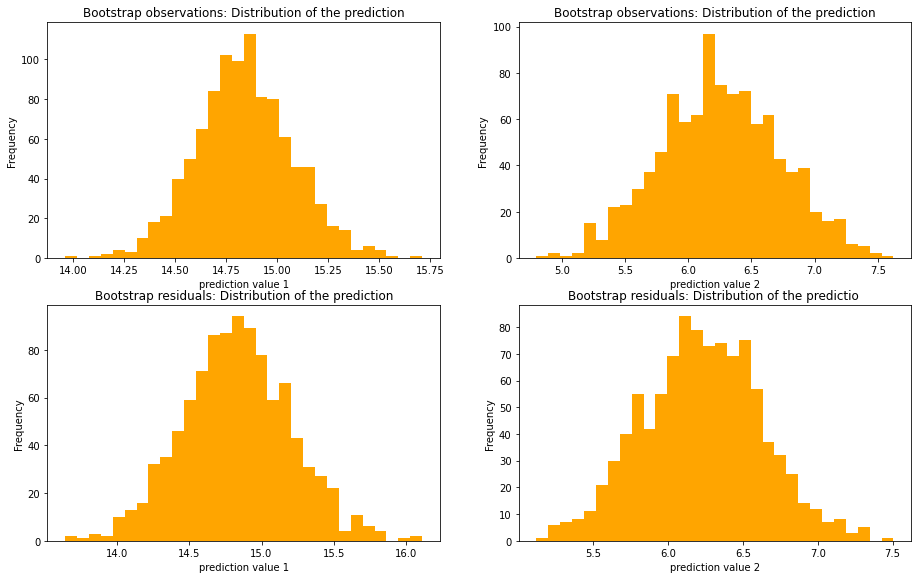

For bootstrap observations method:
Prediction value 1: The mean of the slope is 14.84, the variance of the slope is 0.06
Predction value 2:The mean of the intercept is 6.25, the variance of the interc is 0.22
For bootstrap residuals method:
Predction value 1: The mean of the slope is 14.83, the variance of the slope is 0.14
Predction value 2:The mean of the intercept is 6.23, the variance of the interc is 0.16


In [24]:
#compare the predicted value distribution from these two bootstrap methods when the dataset is conditional variance dataset.

plt.subplot(2,2,1)
plt.hist(y_predict1_var1, bins = 30,color='orange')
plt.xlabel("prediction value 1")
plt.ylabel("Frequency")
plt.title("Bootstrap observations: Distribution of the prediction");


plt.subplot(2,2,2)
plt.hist(y_predict2_var1, bins = 30,color='orange')
plt.xlabel("prediction value 2")
plt.ylabel("Frequency")
plt.title("Bootstrap observations: Distribution of the prediction");


plt.subplot(2,2,3)
plt.hist(y_predict1_var2, bins = 30,color='orange')
plt.xlabel("prediction value 1")
plt.ylabel("Frequency")
plt.title("Bootstrap residuals: Distribution of the prediction");


plt.subplot(2,2,4)
plt.hist(y_predict2_var2, bins = 30,color='orange')
plt.xlabel("prediction value 2")
plt.ylabel("Frequency")
plt.title("Bootstrap residuals: Distribution of the predictio ");

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.8, wspace=0.2, hspace=0.2) 
plt.show()
print('For bootstrap observations method:')
print('Prediction value 1: The mean of the slope is ' + str(round(np.mean(y_predict1_var1),2))+', the variance of the slope is '+ str(round(np.var(y_predict1_var1),2)))
print('Predction value 2:The mean of the intercept is ' + str(round(np.mean(y_predict2_var1),2))+', the variance of the interc is '+ str(round(np.var(y_predict2_var1),2)))
print('For bootstrap residuals method:')
print('Predction value 1: The mean of the slope is ' + str(round(np.mean(y_predict1_var2),2))+', the variance of the slope is '+ str(round(np.var(y_predict1_var2),2)))
print('Predction value 2:The mean of the intercept is ' + str(round(np.mean(y_predict2_var2),2))+', the variance of the interc is '+ str(round(np.var(y_predict2_var2),2)))


As shown in the above figures, for the bootstrap observations method, the variance of the perdiction when the density is less than 1.6g/cm3 is less than that with density larger than 1.6g/cm3. While for the bootstrap residuals method, the variance of both predictions are same, which indicates that the bootstrap residuals method is not suitable for conditional variance dataset.

### Results

The results can be summarized:

1. The linear regression model gives us one set of regression coefficients for the linear relationship, while bootstrap linear regression model gives us several sets of regression coefficients for the linear relationship and helps us understand the confidence interval of these cefficients.

2. Both sample linear regression model and bootstrap linear regression model are sensitive to the outliers. 

3. The bootstrap observations linear regression method performs better than bootstrap residuals method when the dataset is conditional variance dataset.





I hope this was helpful,

*Yuanrui Zhu*

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
